# Wildfire and Land Use Analysis in A Coruna, Spain



### Research Question: 



### Data Sources:

- CIVIO Forest Fire Map: https://civio.es/en/environment/forest-fires-map/
- EFFIS Annual Statistics for Spain https://forest-fire.emergency.copernicus.eu/apps/effis.statistics/estimates
- Average Mean Surface Air Temperature Spain, Climate Change Knowledge Portal For Development Practitioners and Policiy Makers https://climateknowledgeportal.worldbank.org/country/spain/trends-variability-historical
- Tree Data Ministerio para la transcion ecologica y reto demografico (https://www.miteco.gob.es/es.html)


### Python Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import h3
from shapely.geometry import Point, Polygon
import geopandas as gpd
import json
from keplergl import KeplerGl



%matplotlib inline
pd.set_option('display.max_columns', None)

## Forest Data

### Forest Data: Import

In [2]:

lfGIS_data = pd.read_csv("BBDD_FULL_V5.csv", sep=",")
lfGIS_df = lfGIS_data.copy()

lfGIS_df

C:\Users\nicolas\AppData\Local\Temp\ipykernel_30656\3285728577.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  lfGIS_data = pd.read_csv("BBDD_FULL_V5.csv", sep=",")


,Index,Communal Mounts,Population,Latitude,Longitude,Type of tree,CO2 Sink/ft,Wetland,Type of tree (nº),Total Carbon Sink,Total Price (€)
0,8a39240e2047fff,NaN,NaN,43.087568,-9.238841,No tree,0.0,NaN,0.0,0.0,0.00
1,8a392548cd57fff,NaN,NaN,42.936834,-8.223533,Mixed wood,0.01,NaN,2.0,8.0,764.24
2,8a39258ce08ffff,1.0,NaN,43.673497,-7.926853,Oak,0.15,NaN,4.0,120.0,11463.60
3,8a3924299477fff,NaN,NaN,42.914610,-8.777807,No tree,0.0,NaN,0.0,0.0,0.00
4,8a39242600c7fff,NaN,NaN,43.214174,-8.604583,Eucalyptus,2.04,NaN,1.0,1632.0,155904.96
...,...,...,...,...,...,...,...,...,...,...,...
493071,8a3920863d87fff,NaN,NaN,42.809301,-8.358412,No tree,0,NaN,0.0,0.0,0.00
493072,8a39258f0077fff,NaN,NaN,43.697140,-8.057704,Eucalyptus,2.04,NaN,1.0,1632.0,155904.96
493073,8a39246d6c5ffff,1.0,NaN,42.608876,-9.034345,Mixed wood,0.01,NaN,2.0,8.0,764.24
493074,8a39242f1057fff,NaN,NaN,43.018655,-8.678269,No tree,0,NaN,0.0,0.0,0.00


### Forest Data: Cleaning

In [3]:

# Learning from GIS Dataset
# replace nulls with 0
lfGIS_df[["Communal Mounts","Population","CO2 Sink/ft", "Wetland","Type of tree (nº)", "Total Carbon Sink"]] = lfGIS_df[["Communal Mounts","Population","CO2 Sink/ft", "Wetland","Type of tree (nº)", "Total Carbon Sink"]].fillna(0)

# convert from float to int
lfGIS_df[["Communal Mounts","Population", "Wetland","Type of tree (nº)", "Total Carbon Sink"]] = lfGIS_df[["Communal Mounts","Population", "Wetland","Type of tree (nº)", "Total Carbon Sink"]].astype(int)

#replace nulls with string
lfGIS_df[["Type of tree"]] = lfGIS_df[["Type of tree"]].fillna("No tree")

lfGIS_df


,Index,Communal Mounts,Population,Latitude,Longitude,Type of tree,CO2 Sink/ft,Wetland,Type of tree (nº),Total Carbon Sink,Total Price (€)
0,8a39240e2047fff,0,0,43.087568,-9.238841,No tree,0.0,0,0,0,0.00
1,8a392548cd57fff,0,0,42.936834,-8.223533,Mixed wood,0.01,0,2,8,764.24
2,8a39258ce08ffff,1,0,43.673497,-7.926853,Oak,0.15,0,4,120,11463.60
3,8a3924299477fff,0,0,42.914610,-8.777807,No tree,0.0,0,0,0,0.00
4,8a39242600c7fff,0,0,43.214174,-8.604583,Eucalyptus,2.04,0,1,1632,155904.96
...,...,...,...,...,...,...,...,...,...,...,...
493071,8a3920863d87fff,0,0,42.809301,-8.358412,No tree,0,0,0,0,0.00
493072,8a39258f0077fff,0,0,43.697140,-8.057704,Eucalyptus,2.04,0,1,1632,155904.96
493073,8a39246d6c5ffff,1,0,42.608876,-9.034345,Mixed wood,0.01,0,2,8,764.24
493074,8a39242f1057fff,0,0,43.018655,-8.678269,No tree,0,0,0,0,0.00


In [4]:
# Test if there are nulls left
lfGIS_df.isna().sum()

Index                0
Communal Mounts      0
Population           0
Latitude             0
Longitude            0
Type of tree         0
CO2 Sink/ft          0
Wetland              0
Type of tree (nº)    0
Total Carbon Sink    0
Total Price (€)      0
dtype: int64

### Forest Data: Map

In [5]:
# Function to get the centroid of an H3 cell
def h3_to_centroid(h3_index):
    lat, lon = h3.h3_to_geo(h3_index)  # Get the center point of H3 cell
    return lat, lon

In [6]:


# Convert H3 indices to centroids
lfGIS_df["Latitude"], lfGIS_df["Longitude"] = zip(*lfGIS_df["Index"].apply(h3_to_centroid))


# Load the map configuration from a file
config_file = "map_1_config.json"

with open(config_file, "r") as f:
    loaded_config = json.load(f)


# Load into Kepler.gl

map_1 = KeplerGl(height=1000, config=loaded_config)

map_1.add_data(data=lfGIS_df, name="H3 Cells")



map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['H3 Cells'], 'id': 'hl3q5ux'…

In [7]:
# Save map configuration to a JSON file
config_file = "map_1_config.json"

with open(config_file, "w") as f:
    json.dump(map_1.config, f)



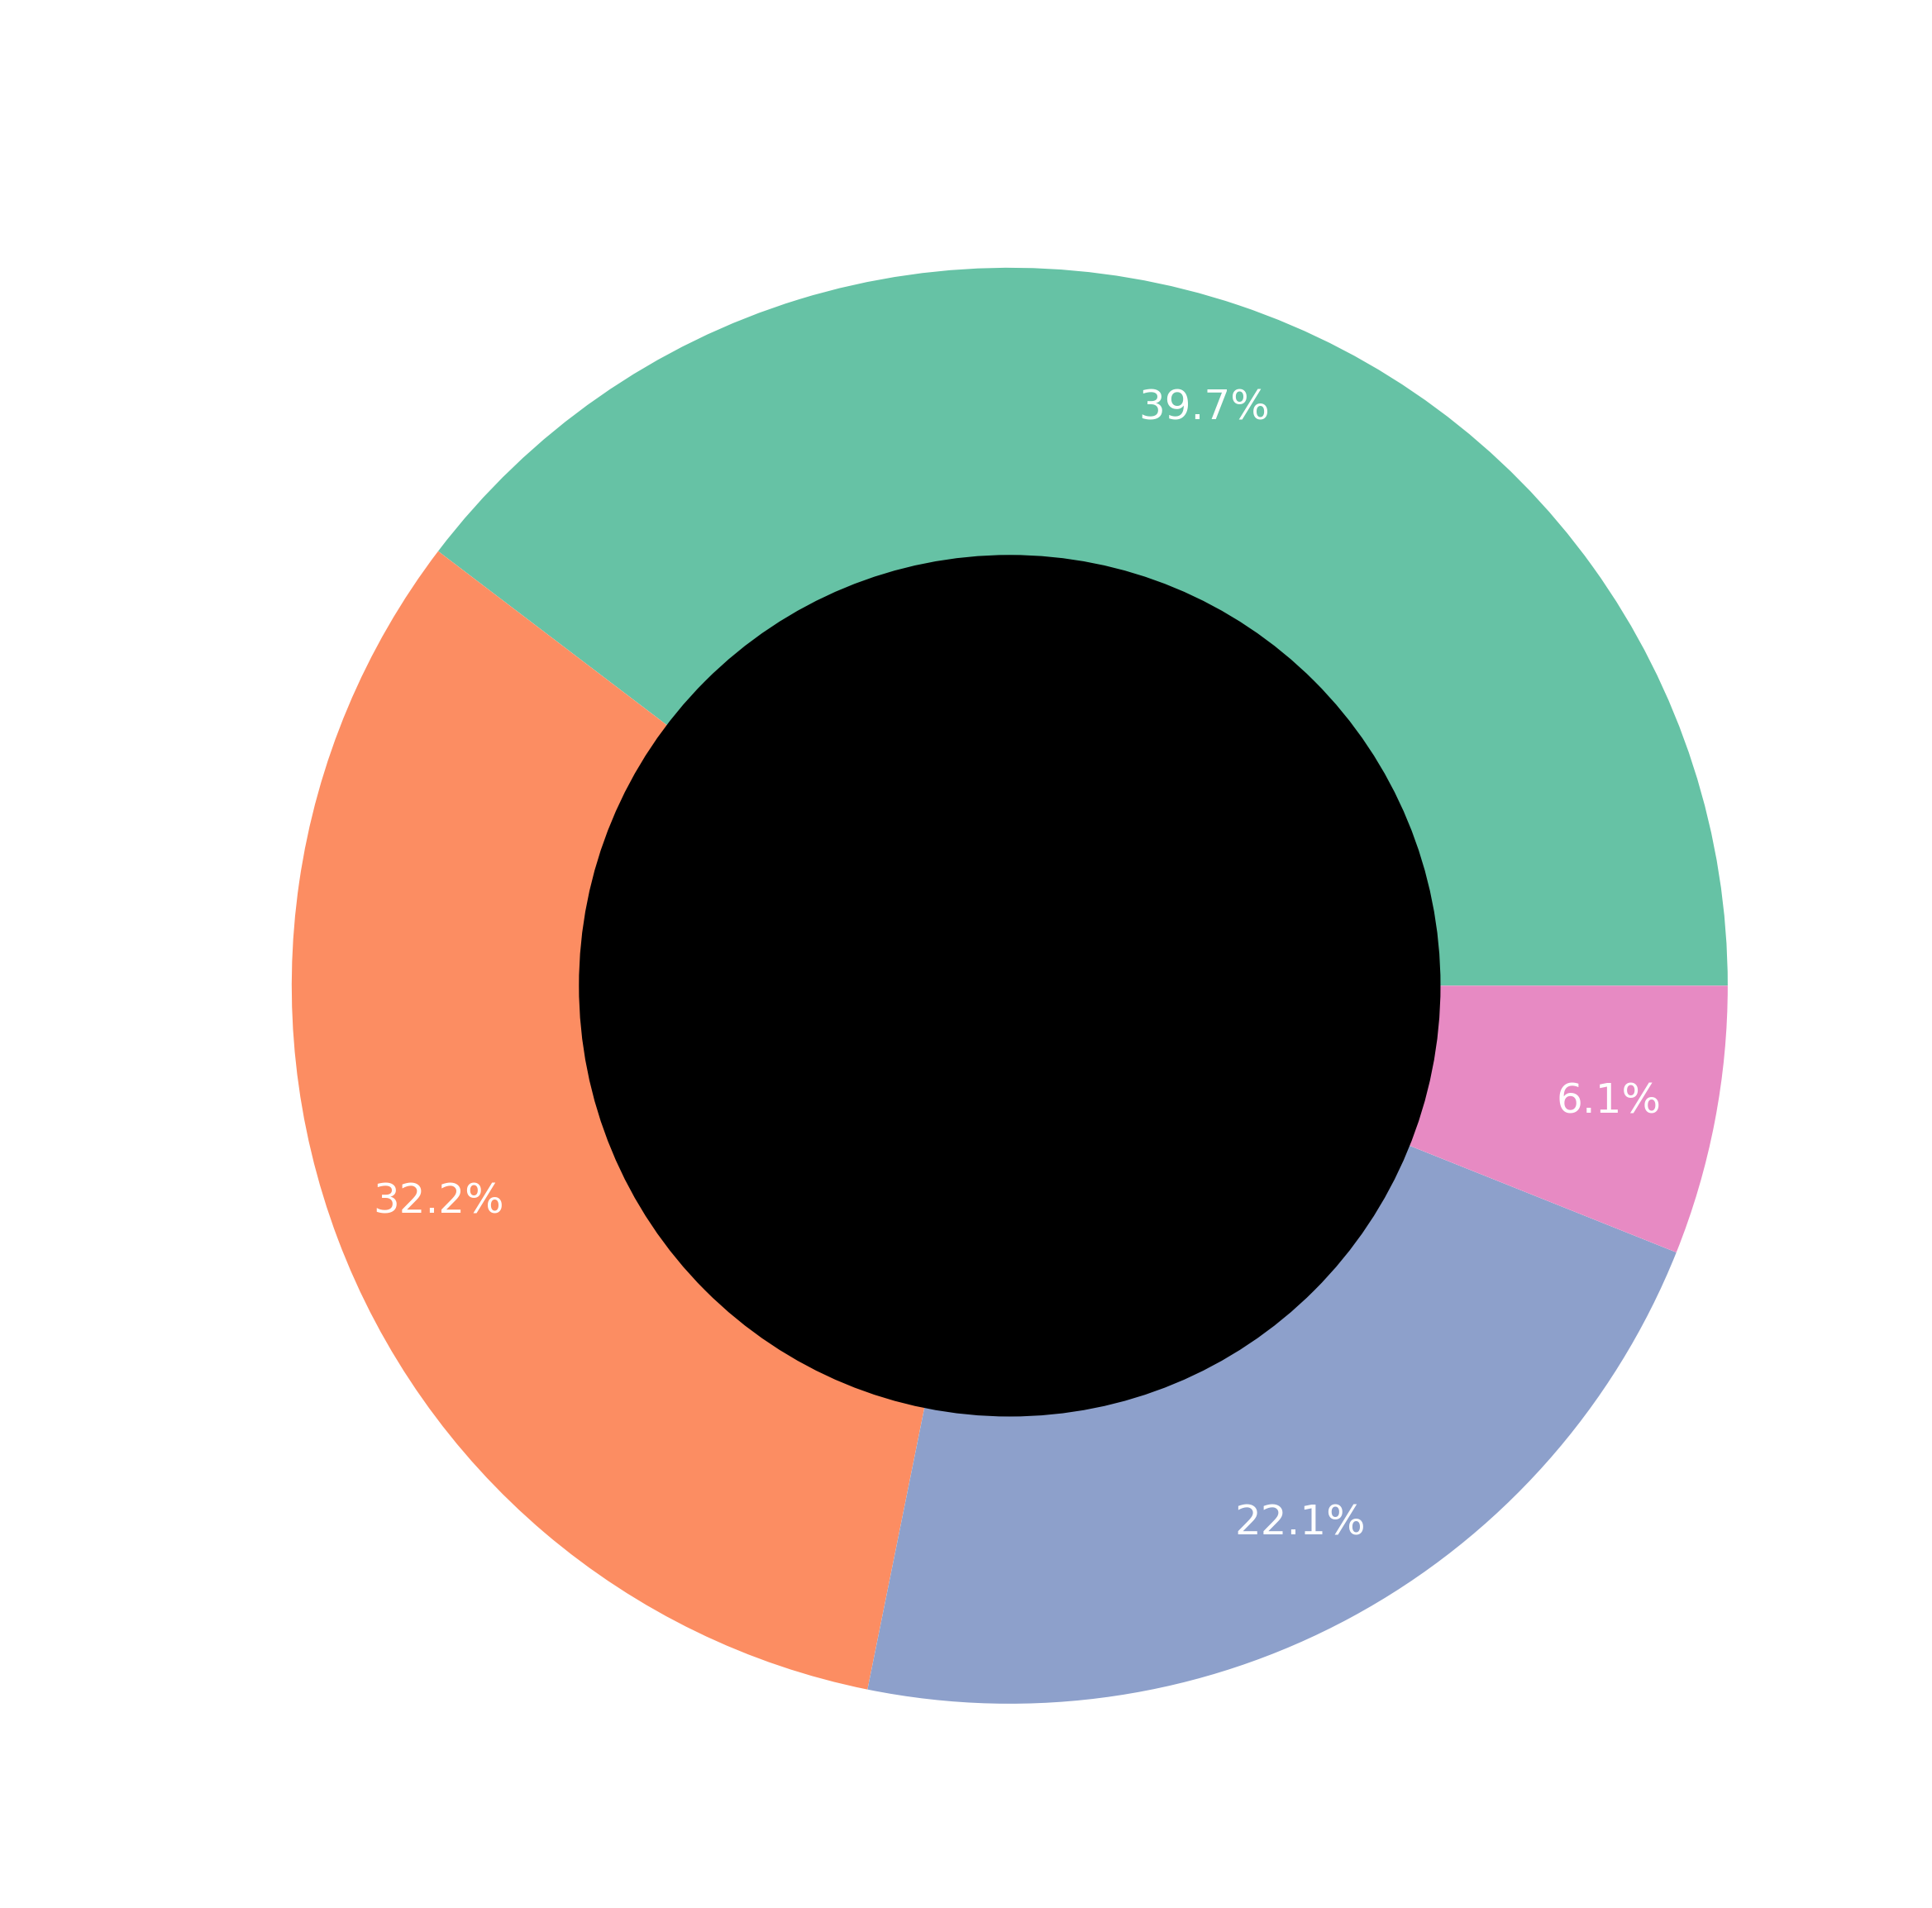

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Modify dataset: Replace "Flowering Plant" and "Birch" with "Other"
lfGIS_df_modified = lfGIS_df.copy()  # Copy to avoid modifying original
lfGIS_df_modified['Type of tree'] = lfGIS_df_modified['Type of tree'].replace(
    {"Flowering plants": "Other", "Birch": "Other", "Chestnut":"Other", "Oak":"Other"}
)

# Count occurrences of each tree type, excluding "No Tree"
tree_counts = lfGIS_df_modified['Type of tree'].value_counts()
tree_counts = tree_counts[tree_counts.index != "No tree"]  # Remove "No Tree"

# Define custom colors for better visualization
custom_colors = sns.color_palette("Set2", len(tree_counts))

# Create figure with transparent background
fig, ax = plt.subplots(figsize=(8, 8), facecolor='none', dpi=300)

# Create a doughnut chart (Pie chart with a center hole)
wedges, texts, autotexts = ax.pie(
    tree_counts, labels=tree_counts.index, autopct='%1.1f%%',
    colors=custom_colors, wedgeprops={'edgecolor': 'none'}, pctdistance=0.85,
    textprops={'color': 'white', 'fontsize': 12}
)
centre_circle = plt.Circle((0, 0), 0.60, fc='black', edgecolor='none')  # Ensures transparency inside
ax.add_artist(centre_circle)

# Customize title
ax.set_title("Distribution of Tree Species", fontsize=16, color='white')

# Remove spines and set transparent background
ax.set_frame_on(False)
fig.patch.set_alpha(0)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


## Fire Data

### Fire Data: Import

In [9]:

wf_data = pd.read_csv("fires-all.csv", sep=",")
wf_df = wf_data.copy()

wf_df.head(10)

,id,superficie,fecha,lat,lng,latlng_explicit,idcomunidad,idprovincia,idmunicipio,municipio,causa,causa_supuesta,causa_desc,muertos,heridos,time_ctrl,time_ext,personal,medios,gastos,perdidas
0,1968290001,14.0,1968-01-01,NaN,NaN,0,4,29,0,INDETERMINADO,2,1,40,0,0,0,360,0,0,0,0
1,1968430003,3.0,1968-01-03,NaN,NaN,0,2,43,0,INDETERMINADO,5,1,0,0,0,0,60,0,0,0,0
2,1968290006,2.0,1968-01-06,NaN,NaN,0,4,29,0,INDETERMINADO,5,1,0,0,0,0,120,0,0,0,0
3,1968430016,600.0,1968-01-07,NaN,NaN,0,2,43,0,INDETERMINADO,3,1,20,0,0,0,1440,35,1,0,0
4,1968120007,8.2,1968-01-07,NaN,NaN,0,9,12,0,INDETERMINADO,3,1,20,0,0,0,120,0,0,0,0
5,1968460044,1.0,1968-01-07,NaN,NaN,0,9,46,0,INDETERMINADO,5,1,0,0,0,0,120,0,0,0,0
6,1968430004,1.8,1968-01-09,NaN,NaN,0,2,43,0,INDETERMINADO,2,1,40,0,0,0,120,0,0,0,0
7,1968440009,1.5,1968-01-09,NaN,NaN,0,10,44,0,INDETERMINADO,2,1,40,0,0,0,120,0,0,0,0
8,1968250010,35.0,1968-01-10,NaN,NaN,0,2,25,0,INDETERMINADO,4,1,99,0,0,0,1440,39,0,0,0
9,1968490017,1.0,1968-01-10,NaN,NaN,0,17,49,0,INDETERMINADO,2,1,40,0,0,0,59,0,0,0,0


### Fire Data: Data Cleaning

In [10]:
# translate and rename columns from Spanish to English
wf_df = wf_df.rename(columns={"superficie": "area", "fecha": "date","municipio": "municipality", "causa": "cause", "muertos": "deaths","heridos": "injured", "personal":"personnel", "gastos": "expenses", "perdidas": "economic_losses"})

# drop unused columns
wf_df = wf_df[["area", "date", "lat", "lng", "municipality", "cause", "deaths", "injured", "personnel", "expenses", "economic_losses"]]

# Convert "date" column to datetime format
wf_df["date"] = pd.to_datetime(wf_df["date"], errors="coerce")

# Filter out rows where the date is before 1983
wf_df = wf_df[wf_df["date"] >= "1983-01-01"]

# Filter out rows where the date is after 2016
wf_df = wf_df[wf_df["date"] < "2017-01-01"]

# drop rows without location
wf_df = wf_df.dropna(subset=["lat"])

# replace municipality nulls with string
wf_df[["municipality"]] = wf_df[["municipality"]].fillna("UNKNOWN")
wf_df[["municipality"]] = wf_df[["municipality"]]

# capitalize municipality names
wf_df["municipality"] = wf_df["municipality"].str.lower().str.title()

# rename cause values
# 1 = caused by lightning
# 2 = caused by accident
# 3 = intentional
# 4 = alleged intentional
# 5 = unknown reason
# 6 = reproduced fire

wf_df["cause"] = wf_df["cause"].replace({1: "caused by lightning", 2 : "caused by accident", 3 : "intentional", 4 : "alleged intentional", 5 : "unknown cause", 6 : "reproduced fire"})

# reset index
wf_df = wf_df.reset_index(drop=True)

# Test if there are nulls left
print(wf_df.isna().sum())

wf_df




area               0
date               0
lat                0
lng                0
municipality       0
cause              0
deaths             0
injured            0
personnel          0
expenses           0
economic_losses    0
dtype: int64


,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses
0,2.00,1983-01-04,38.923284,-0.379678,Lutxent,unknown cause,0,0,13,0,0
1,15.00,1983-01-05,40.138912,-0.675542,Rubielos De Mora,caused by accident,0,0,78,1,0
2,15.00,1983-01-05,39.308041,-0.706515,Dos Aguas,unknown cause,0,0,63,0,2
3,10.00,1983-01-06,43.082343,-3.944677,Luena,alleged intentional,0,0,10,0,0
4,95.00,1983-01-06,40.250669,-0.017537,Sierra Engarcerán,alleged intentional,0,0,22,0,0
...,...,...,...,...,...,...,...,...,...,...,...
223297,5.22,2016-12-31,40.167345,-5.886924,Navaconcejo,alleged intentional,0,0,15,0,0
223298,17.18,2016-12-31,40.170685,-5.914307,Navaconcejo,alleged intentional,0,0,15,0,0
223299,2.00,2016-12-31,42.221643,-7.193078,Vilariño De Conso,alleged intentional,0,0,8,0,0
223300,1.58,2016-12-31,42.250444,-7.350834,Chandrexa De Queixa,alleged intentional,0,0,2,0,0


In [11]:
wf_df[["lat","lng"]]

,lat,lng
0,38.923284,-0.379678
1,40.138912,-0.675542
2,39.308041,-0.706515
3,43.082343,-3.944677
4,40.250669,-0.017537
...,...,...
223297,40.167345,-5.886924
223298,40.170685,-5.914307
223299,42.221643,-7.193078
223300,42.250444,-7.350834


In [12]:
threes_in_df = wf_df[wf_df["cause"] ==3]

print(threes_in_df.size)

threes_in_df.head(40)

0


,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses


### Fire Data: Amount of Wildfires per Year

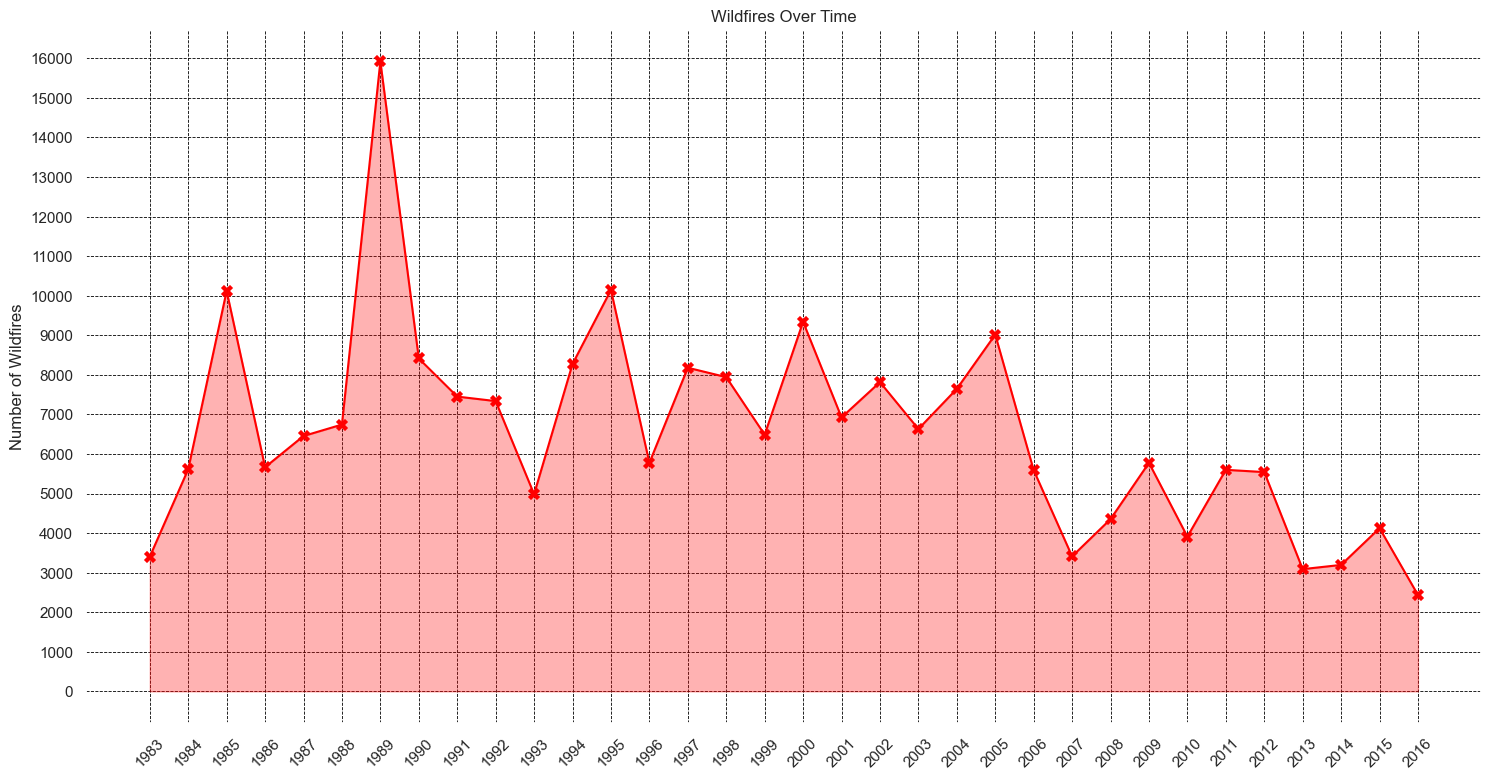

In [13]:
# Extract the year and count the number of wildfires per year
wildfire_counts = wf_df.groupby(wf_df["date"].dt.year).size().reset_index(name="count")

# Set Seaborn style
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(18, 9))
sns.lineplot(x=wildfire_counts["date"], y=wildfire_counts["count"], marker="X", markersize=8, markerfacecolor="red", markeredgecolor="red", markeredgewidth=0.1, color="red")
plt.fill_between(wildfire_counts["date"], wildfire_counts["count"], alpha=0.3, color="red")  # Fill the area

plt.xticks(wildfire_counts["date"], rotation=45)  # Set explicit years


# Set y-axis in steps of 1000
y_max = wildfire_counts["count"].max()  # Find max wildfire count
y_ticks = np.arange(0, y_max + 1000, 1000)  # Generate ticks in steps of 1000
plt.yticks(y_ticks)

# Customize the chart
plt.xlabel("")
plt.ylabel("Number of Wildfires")
plt.title("Wildfires Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(color="black", linestyle="--", linewidth=0.6)
plt.gca().set_facecolor("white")
plt.gcf().set_facecolor("white") 

# Show the plot
plt.show()

### Fire Data: Map

In [14]:
# Load the map configuration from a file
config_file = "map_2_config.json"

with open(config_file, "r") as f:
    loaded_config = json.load(f)

# Create Kepler map
map_2 = KeplerGl(height=800, config=loaded_config)

# Add data
map_2.add_data(data= wf_df, name="Wildfire Locations")

# Add tree/forest data layer
map_2.add_data(data=lfGIS_df, name="Forest Data")


map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Forest Data'], 'id': '0uevm…

In [15]:
# Save map configuration to a JSON file
config_file = "map_2_config.json"

with open(config_file, "w") as f:
    json.dump(map_2.config, f)




### Import Region Polygon

In [17]:

# Load Spanish Regions GeoJSON file
regions_data = gpd.read_file("es.json")
regions_gdf = regions_data.copy()

regions_gdf

,source,id,name,geometry
0,https://simplemaps.com,ESNC,Navarra,"MULTIPOLYGON (((-1.74973 43.29479, -1.74736 43..."
1,https://simplemaps.com,ESPV,País Vasco,"POLYGON ((-1.74973 43.29479, -1.74994 43.29475..."
2,https://simplemaps.com,ESRI,La Rioja,"POLYGON ((-2.40607 42.4971, -2.38447 42.49467,..."
3,https://simplemaps.com,ESCT,Cataluña,"MULTIPOLYGON (((0.52376 40.52616, 0.51891 40.5..."
4,https://simplemaps.com,ESAR,Aragon,"POLYGON ((-1.85241 42.00121, -1.84128 42.00188..."
5,https://simplemaps.com,ESEX,Extremadura,"POLYGON ((-6.87451 40.27919, -6.86219 40.27175..."
6,https://simplemaps.com,ESGA,Galicia,"POLYGON ((-7.04692 43.48368, -7.04889 43.47789..."
7,https://simplemaps.com,ESCL,Castilla y León,"MULTIPOLYGON (((-3.42379 43.14062, -3.36242 43..."
8,https://simplemaps.com,ESVC,Comunidad Valenciana,"MULTIPOLYGON (((0.17304 40.7309, 0.19899 40.72..."
9,https://simplemaps.com,ESMC,Murcia,"MULTIPOLYGON (((-1.02213 38.65454, -1.00544 38..."


### Regions Data: Clean Data

In [18]:

regions_gdf = regions_gdf.drop(columns=["source", "id"])

regions_gdf = regions_gdf.rename(columns={"name": "region"})

regions_gdf

,region,geometry
0,Navarra,"MULTIPOLYGON (((-1.74973 43.29479, -1.74736 43..."
1,País Vasco,"POLYGON ((-1.74973 43.29479, -1.74994 43.29475..."
2,La Rioja,"POLYGON ((-2.40607 42.4971, -2.38447 42.49467,..."
3,Cataluña,"MULTIPOLYGON (((0.52376 40.52616, 0.51891 40.5..."
4,Aragon,"POLYGON ((-1.85241 42.00121, -1.84128 42.00188..."
5,Extremadura,"POLYGON ((-6.87451 40.27919, -6.86219 40.27175..."
6,Galicia,"POLYGON ((-7.04692 43.48368, -7.04889 43.47789..."
7,Castilla y León,"MULTIPOLYGON (((-3.42379 43.14062, -3.36242 43..."
8,Comunidad Valenciana,"MULTIPOLYGON (((0.17304 40.7309, 0.19899 40.72..."
9,Murcia,"MULTIPOLYGON (((-1.02213 38.65454, -1.00544 38..."


### Check in which region wildfires happened

In [19]:


# Convert wf_df into a GeoDataFrame with Point geometry
wf_df["geometry"] = wf_df.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
wildfire_gdf = gpd.GeoDataFrame(wf_df, geometry="geometry", crs="EPSG:4326")  # Set CRS to WGS84


In [20]:
print(regions_gdf.crs)  # Check CRS of regions


EPSG:4326


In [21]:
# assign each wildfire to a region
wf_df = gpd.sjoin(wildfire_gdf, regions_gdf, how="left", predicate="within")

wf_df = wf_df.drop(columns = ["geometry", "index_right"])

wf_df.head(20)  # Replace "region_name" with actual column


,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses,region
0,2.0,1983-01-04,38.923284,-0.379678,Lutxent,unknown cause,0,0,13,0,0,Comunidad Valenciana
1,15.0,1983-01-05,40.138912,-0.675542,Rubielos De Mora,caused by accident,0,0,78,1,0,Aragon
2,15.0,1983-01-05,39.308041,-0.706515,Dos Aguas,unknown cause,0,0,63,0,2,Comunidad Valenciana
3,10.0,1983-01-06,43.082343,-3.944677,Luena,alleged intentional,0,0,10,0,0,Cantabria
4,95.0,1983-01-06,40.250669,-0.017537,Sierra Engarcerán,alleged intentional,0,0,22,0,0,Comunidad Valenciana
5,6.0,1983-01-06,39.890262,-1.032826,Alpuente,unknown cause,0,0,10,0,0,Comunidad Valenciana
6,20.0,1983-01-07,42.153582,2.467892,"Preses, Les",unknown cause,0,0,45,0,1,Cataluña
7,4.0,1983-01-08,40.567680,-0.038429,Morella,alleged intentional,0,0,26,0,0,Comunidad Valenciana
8,3.0,1983-01-08,39.837197,-0.598126,Altura,unknown cause,0,0,0,0,1,Comunidad Valenciana
9,3.0,1983-01-10,40.469379,-1.262680,Cella,unknown cause,0,0,3,0,1,Aragon


### Check which region has most fires

C:\Users\nicolas\AppData\Local\Temp\ipykernel_30656\1981321760.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wildfires_by_region, x="count", y="region", palette="Reds_r", edgecolor="none", ax=ax)


<module 'matplotlib.pyplot' from 'c:\\Users\\nicolas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

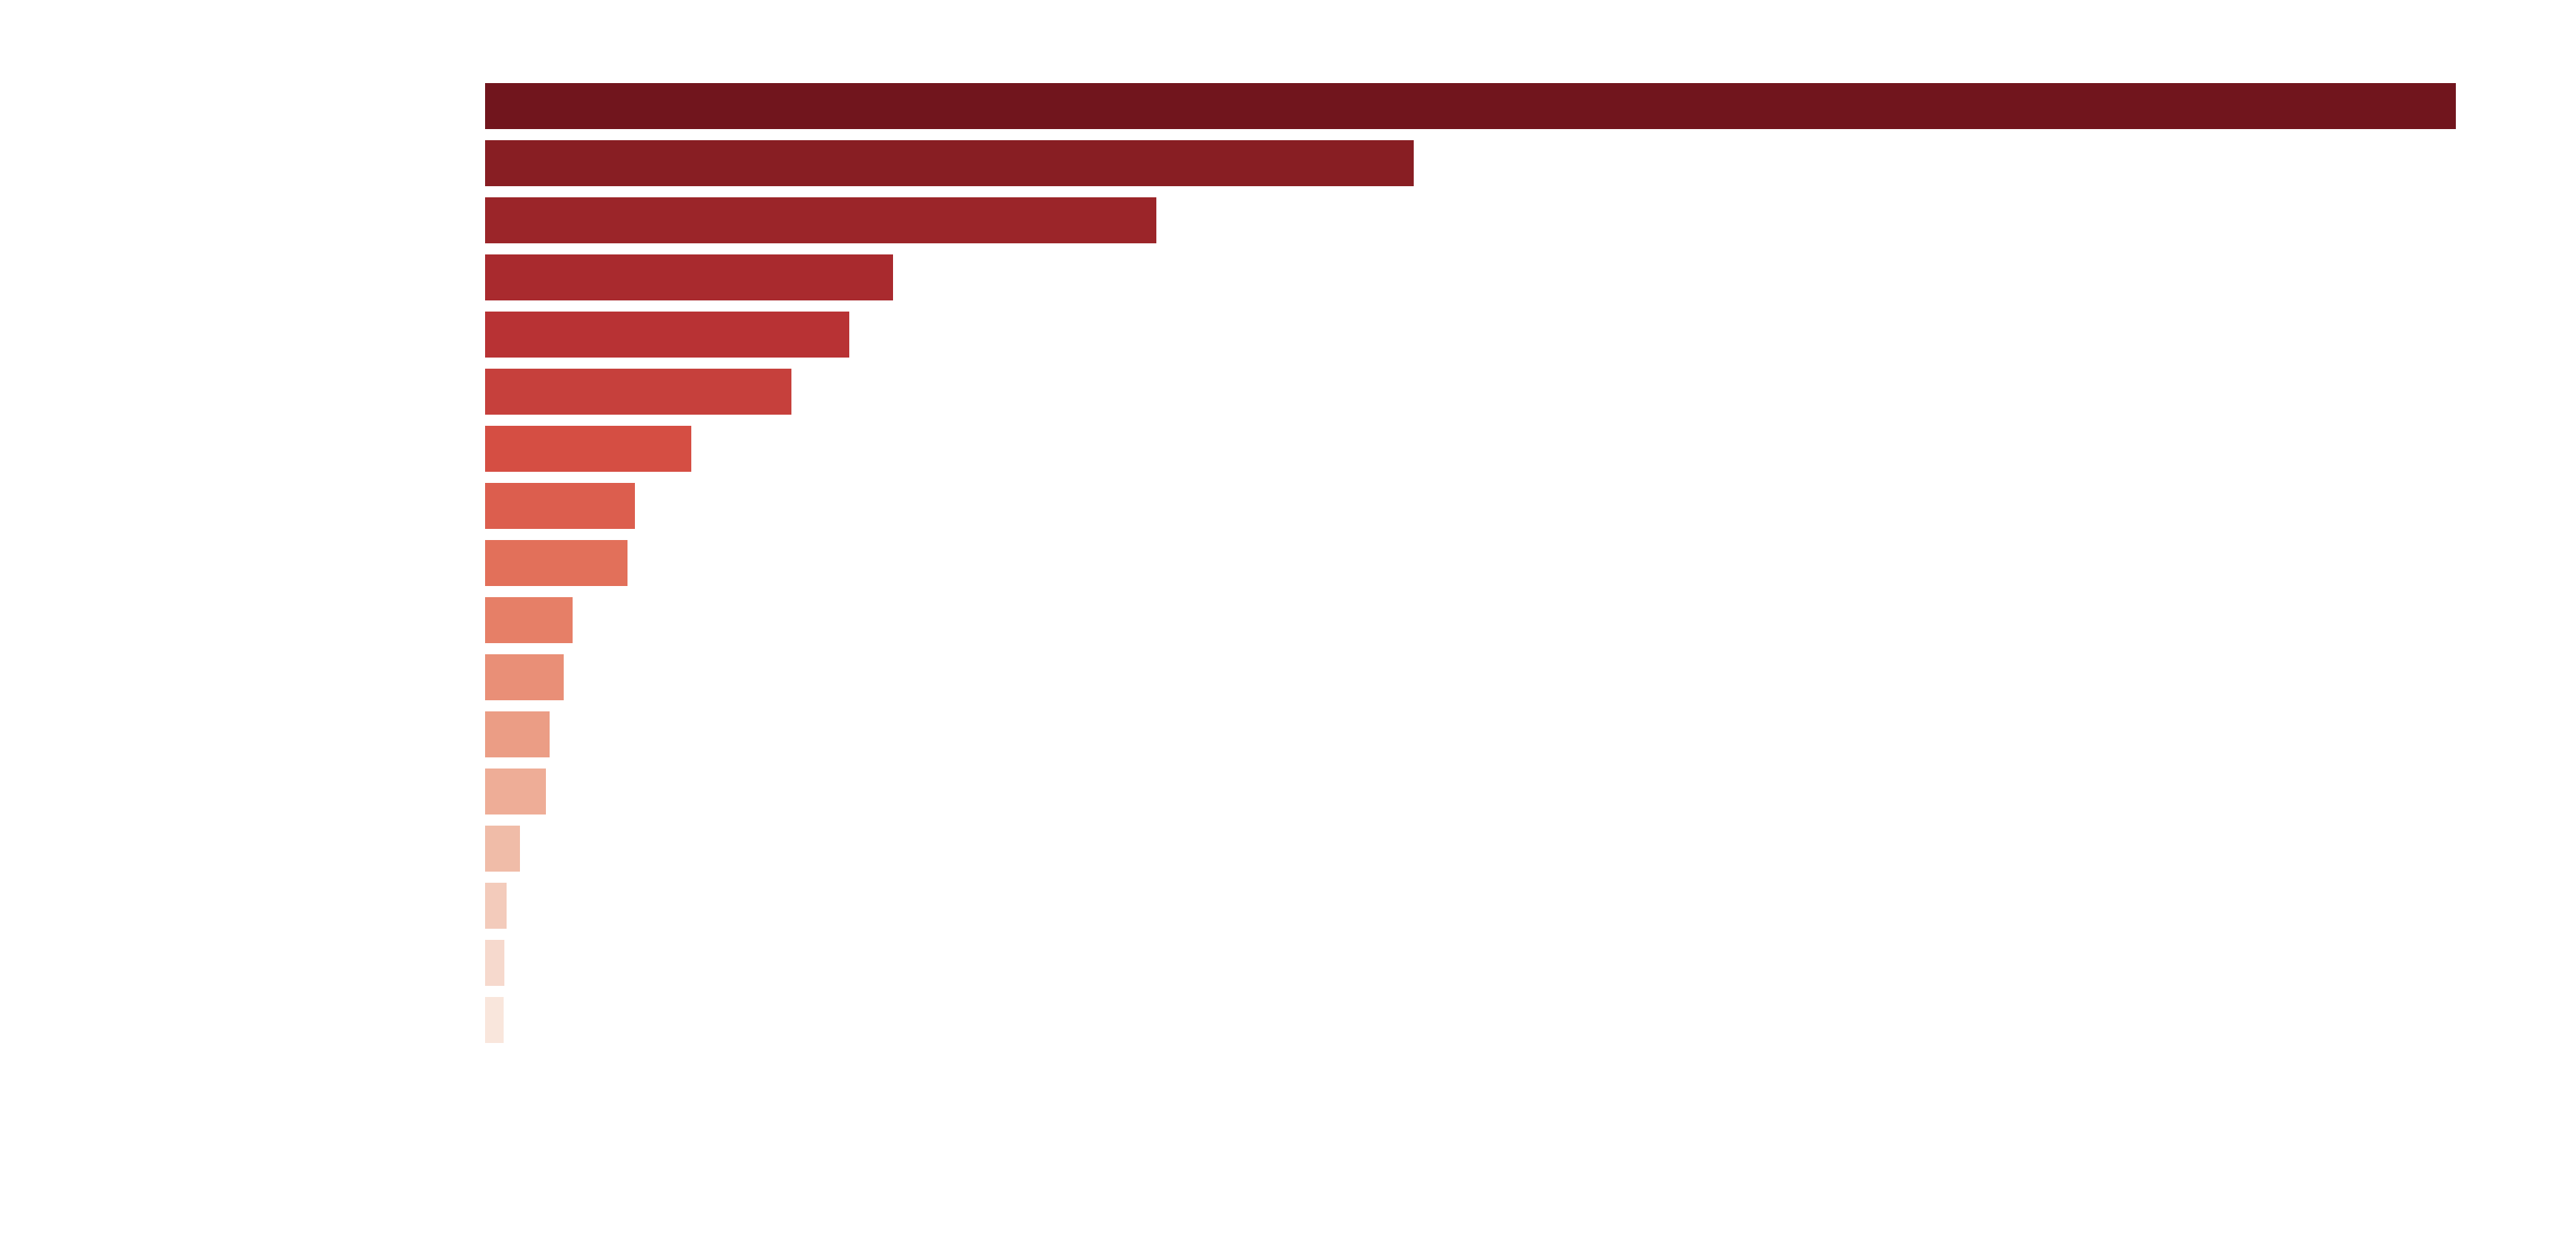

In [45]:


# Count the number of wildfires per region
wildfires_by_region = wf_df["region"].value_counts().reset_index()
wildfires_by_region.columns = ["region", "count"]  # Rename columns


sns.set_style("ticks")  
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none', dpi=300)
sns.barplot(data=wildfires_by_region, x="count", y="region", palette="Reds_r", edgecolor="none", ax=ax)
ax.set_xlabel("Number of Wildfires", fontsize=14, color='white')  
ax.set_ylabel("Region", fontsize=14, color='white')  
ax.set_title("Wildfires Per Region", fontsize=16, color='white')  
ax.tick_params(axis='x', colors='white', labelsize=12)
ax.tick_params(axis='y', colors='white', labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.7, color='white')

# Remove spines (borders) to ensure transparency
for spine in ax.spines.values():
    spine.set_visible(False)


ax.set_facecolor('none')  
fig.patch.set_alpha(0)


plt


<module 'matplotlib.pyplot' from 'c:\\Users\\nicolas\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

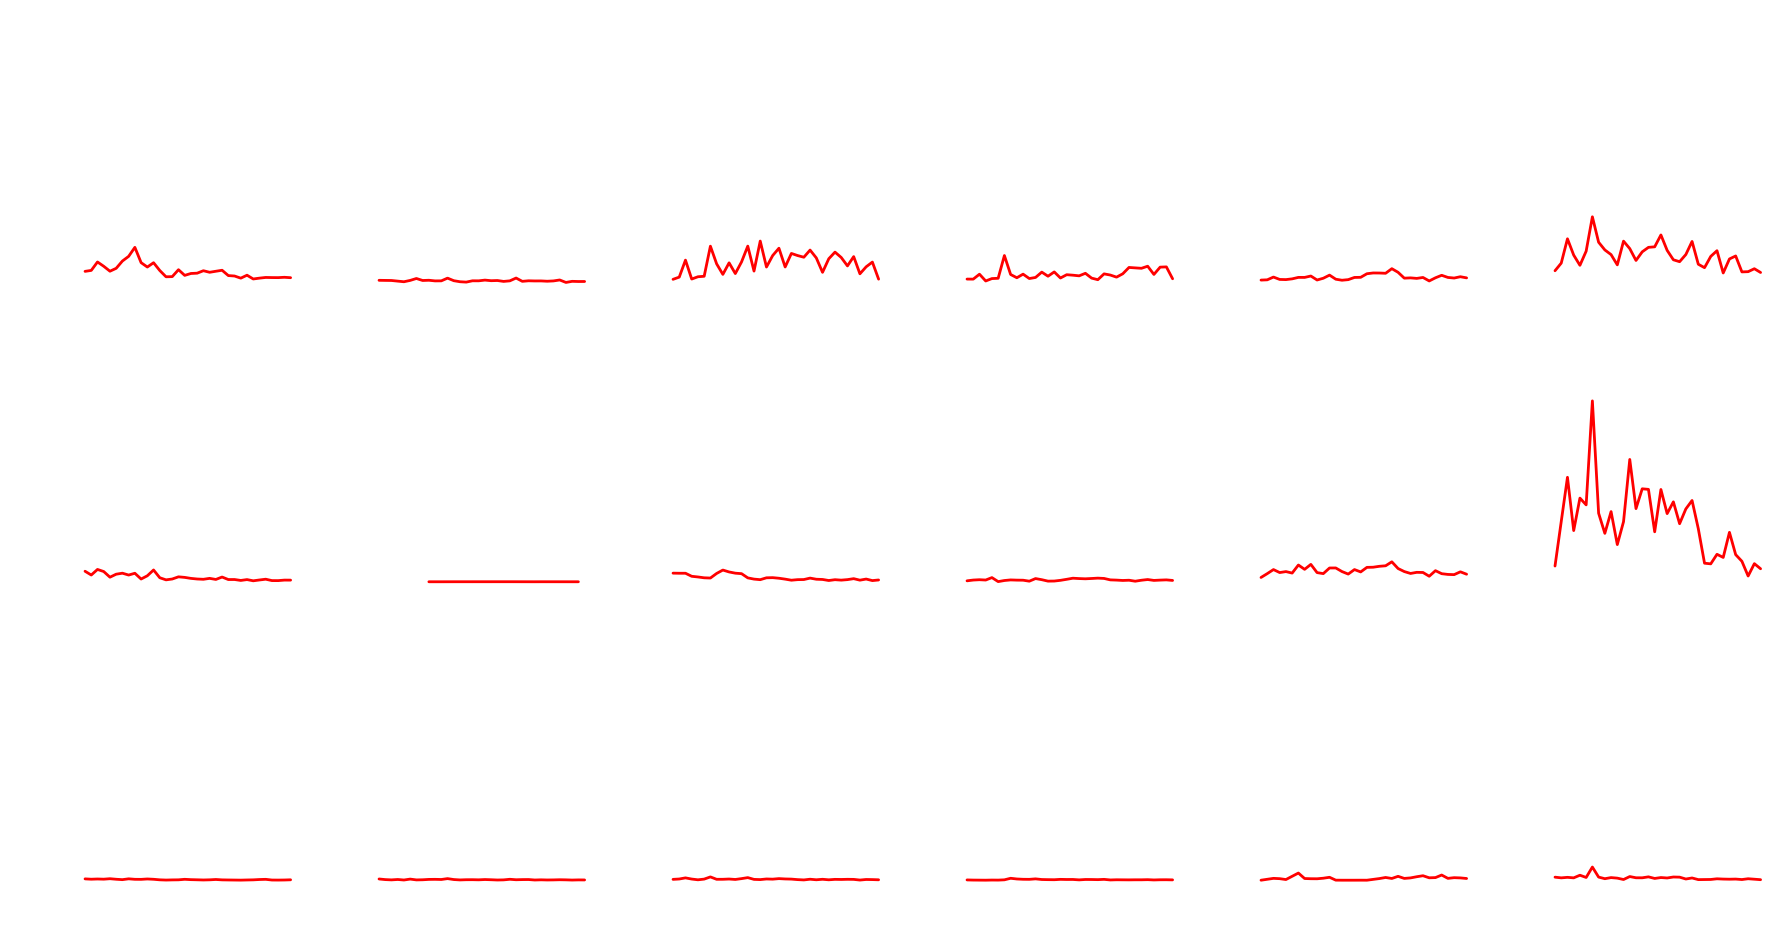

In [46]:

# Ensure date is in datetime format
wf_df["date"] = pd.to_datetime(wf_df["date"], errors="coerce")

# Extract year
wf_df["year"] = wf_df["date"].dt.year

# Count wildfires per region and year
wildfires_by_region_year = wf_df.groupby(["region", "year"]).size().reset_index(name="count")

# Seaborn
sns.set_style("ticks")  
g = sns.FacetGrid(wildfires_by_region_year, col="region", col_wrap=6, height=3, aspect=1, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="count", color="red", linewidth=2)
for ax in g.axes.flat:
    ax.set_facecolor('none') 

# Customize subplot titles (Set to white)
g.set_titles("{col_name}", size=12, color='white')  

# Customize axis labels
g.set_axis_labels("", "Number of Wildfires")
for ax in g.axes.flat:
    ax.set_ylabel("Number of Wildfires", fontsize=12, color='white')
    ax.set_xlabel("Year", fontsize=12, color='white')

# Make tick labels pure white
for ax in g.axes.flat:
    ax.tick_params(axis='x', colors='white', labelsize=10)
    ax.tick_params(axis='y', colors='white', labelsize=10)

# Set overall title in white
plt.suptitle("Wildfire Trends by Region", fontsize=16, color='white', y=1.05)

# Add white grid lines
for ax in g.axes.flat:
    ax.grid(True, linestyle="--", alpha=0.7, color='white')

# Remove spines (borders) to ensure transparency
for ax in g.axes.flat:
    for spine in ax.spines.values():
        spine.set_visible(False)

# Make figure background fully transparent
g.figure.patch.set_alpha(0)

# Adjust spacing to prevent label overlap
g.fig.subplots_adjust(hspace=0.5, wspace=0.3)

plt


### (Alleged) Intentional Wildfires Galicia

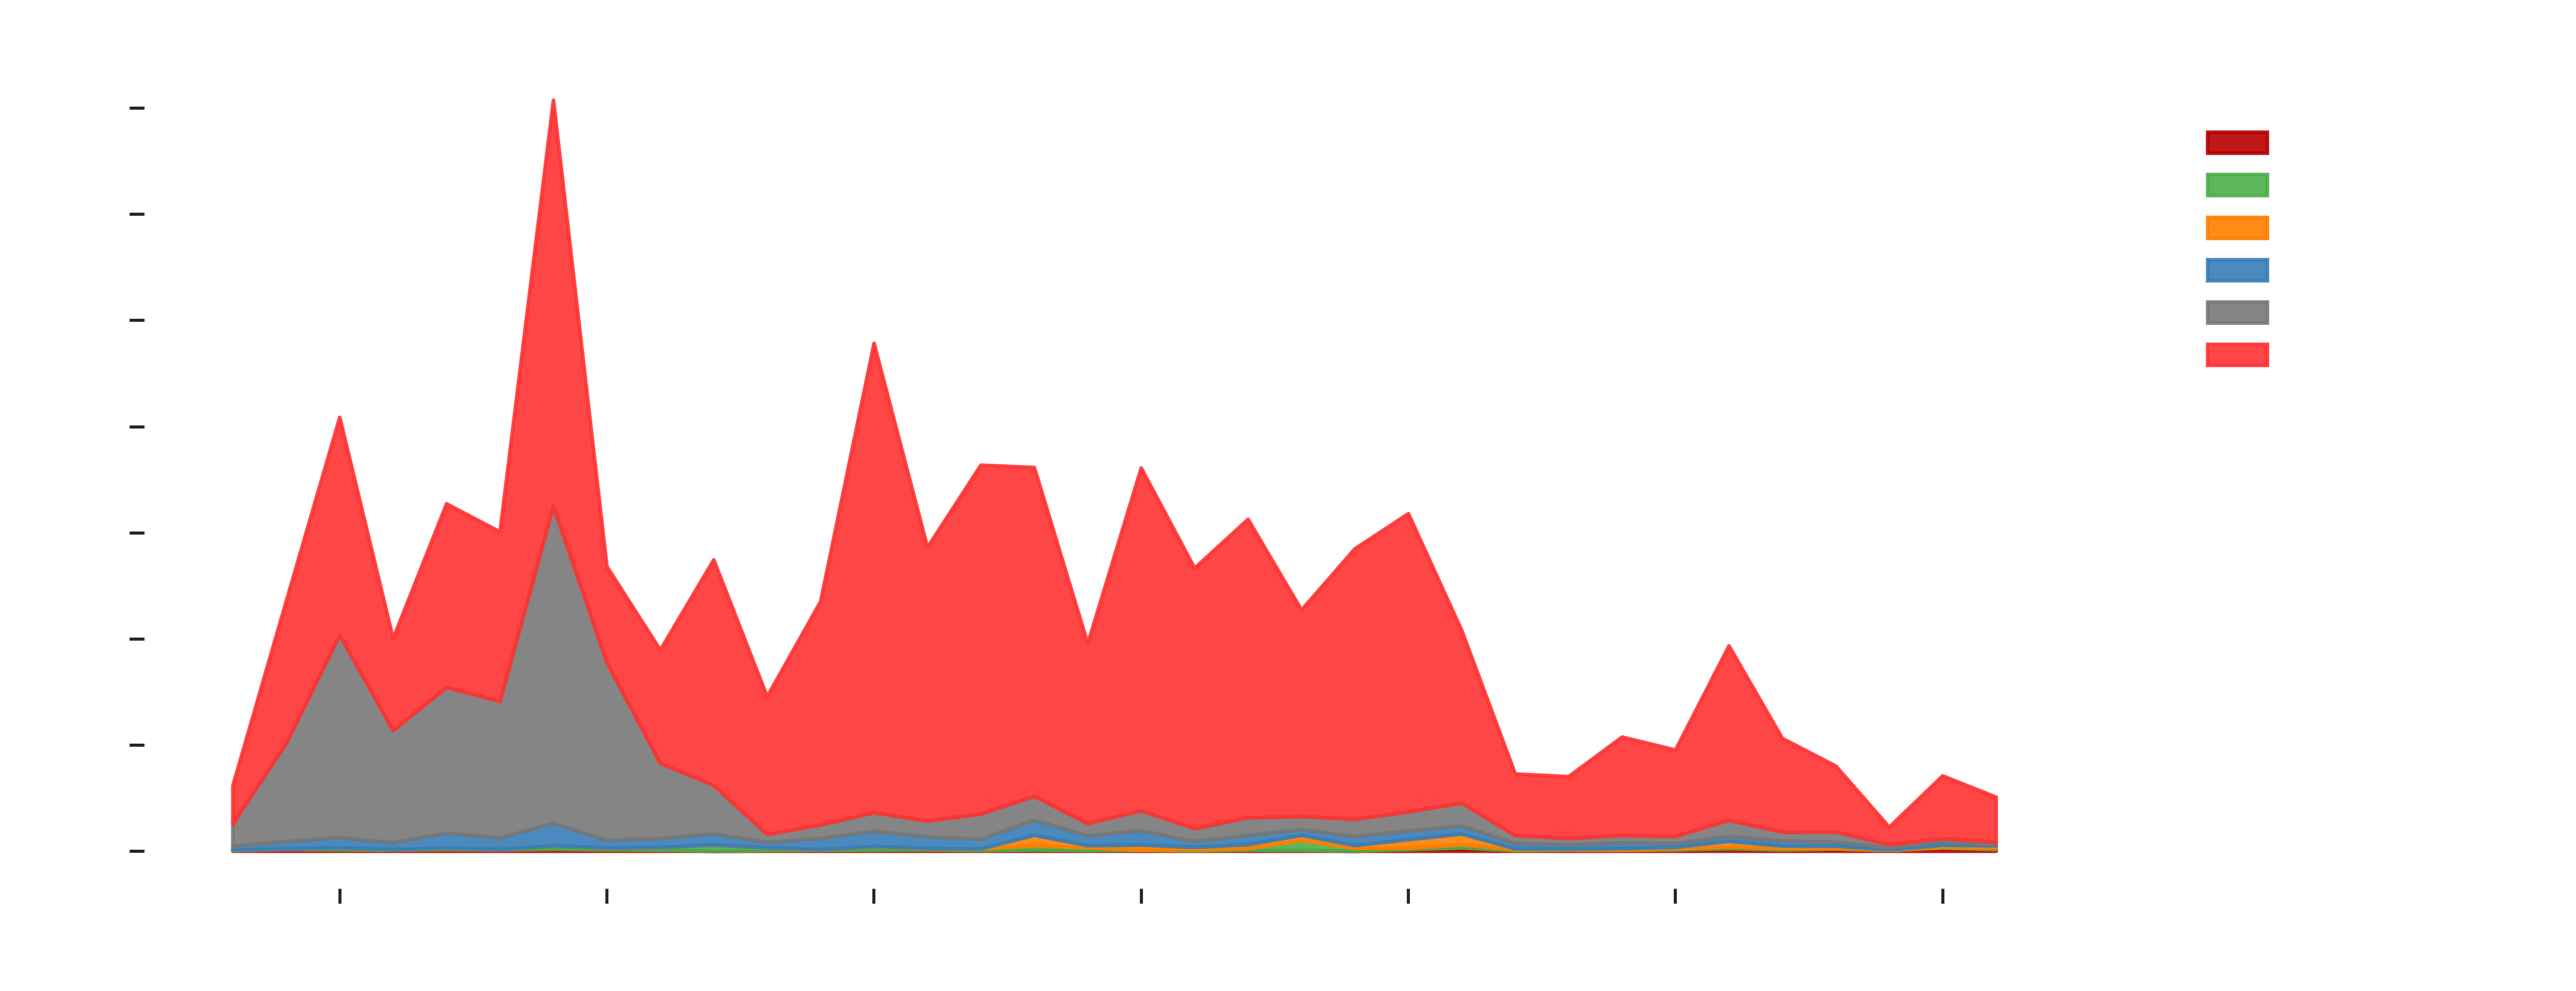

In [ ]:
# Ensure date is in datetime format
wf_df["date"] = pd.to_datetime(wf_df["date"], errors="coerce")

# Extract year
wf_df["year"] = wf_df["date"].dt.year

# Filter dataset for Galicia
galicia_df = wf_df[wf_df["region"] == "Galicia"]

# Group by year and cause
galicia_trends = galicia_df.groupby(["year", "cause"]).size().reset_index(name="count")

# Pivot the dataframe to make 'cause' columns for stacking
galicia_pivot = galicia_trends.pivot(index="year", columns="cause", values="count").fillna(0)

# Sort causes by total number of fires (largest first)
cause_order = galicia_pivot.sum().sort_values(ascending=False).index

# Reverse the order so the largest is at the bottom
cause_order = cause_order[::-1]

# Reorder columns in the DataFrame
galicia_pivot = galicia_pivot[cause_order]

# 🔹 Define your own custom colors for each cause
custom_colors = [
    "#B90000",  # Dark Red (Intentional)
    "#4DAF4A",  # Green (Lightning)
    "#FF7F00",  # Orange (Reproduced)
    "#377EB8",  # Blue (Accident)
    "#787878",  # Gray (Unknown)
    "#FF3333",  # Red (Alleged Intentional)
]  

# Ensure the number of colors matches the number of causes
if len(custom_colors) < len(cause_order):
    raise ValueError("Not enough colors specified for all causes!")

# Set Seaborn style to remove default background tint
sns.set_style("ticks")  

# Create figure with transparent background
fig, ax = plt.subplots(figsize=(14, 6), facecolor='none', dpi=300)

# Plot each area separately to ensure correct outline color
for i, cause in enumerate(cause_order):
    ax.fill_between(
        galicia_pivot.index, 
        galicia_pivot.iloc[:, :i+1].sum(axis=1), 
        galicia_pivot.iloc[:, :i].sum(axis=1) if i > 0 else 0, 
        color=custom_colors[i], alpha=0.9, edgecolor=custom_colors[i], linewidth=1.5
    )

# Customize the plot
ax.set_xlabel("", fontsize=14, color='white')
ax.set_ylabel("Number of Wildfires", fontsize=14, color='white')
ax.set_title("Wildfires in Galicia by Cause", fontsize=16, color='white')

# Rotate x-axis labels and change their color
plt.xticks(rotation=45, color='white')  
plt.yticks(color='white')

# Add white grid lines
ax.grid(color="white", linestyle="--", linewidth=0.6)

# Set legend with transparent background
legend = ax.legend(cause_order, title="Cause", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, frameon=False)
plt.setp(legend.get_texts(), color='white')  # Make legend text white
legend.get_title().set_color('white')

# Remove spines (borders) to ensure transparency
for spine in ax.spines.values():
    spine.set_visible(False)

# Make figure and axes background fully transparent
ax.set_facecolor('none')  
fig.patch.set_alpha(0)

# Show the plot
plt.show()


### Wildfires Galicia

In [25]:
galicia_df = wf_df[wf_df['region'] == 'Galicia']

galicia_df

,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses,region,year
24,2.00,1983-01-16,42.542185,-8.449205,Cotobade,unknown cause,0,0,5,0,0,Galicia,1983
27,6.00,1983-01-16,42.102572,-8.415920,"Neves, As",alleged intentional,0,0,4,0,0,Galicia,1983
32,3.00,1983-01-17,43.629834,-7.367642,Foz,alleged intentional,0,0,11,0,0,Galicia,1983
34,40.00,1983-01-18,43.018968,-7.408954,Castroverde,unknown cause,0,0,17,0,0,Galicia,1983
35,1.50,1983-01-19,42.213418,-8.314843,"Cañiza, A",caused by accident,0,0,2,0,1,Galicia,1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223287,52.49,2016-12-31,42.170829,-7.262819,Vilariño De Conso,alleged intentional,0,0,11,0,18208,Galicia,2016
223289,13.32,2016-12-31,42.161112,-7.248038,Vilariño De Conso,alleged intentional,0,0,9,0,0,Galicia,2016
223295,19.00,2016-12-31,42.119041,-7.400069,Laza,alleged intentional,0,0,9,0,0,Galicia,2016
223299,2.00,2016-12-31,42.221643,-7.193078,Vilariño De Conso,alleged intentional,0,0,8,0,0,Galicia,2016


In [26]:


galicia_df['Index'] = galicia_df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lng'], 10), axis=1)

galicia_df


C:\Users\nicolas\AppData\Local\Temp\ipykernel_30656\3374144117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  galicia_df['Index'] = galicia_df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lng'], 10), axis=1)


,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses,region,year,Index
24,2.00,1983-01-16,42.542185,-8.449205,Cotobade,unknown cause,0,0,5,0,0,Galicia,1983,8a39208d2cdffff
27,6.00,1983-01-16,42.102572,-8.415920,"Neves, As",alleged intentional,0,0,4,0,0,Galicia,1983,8a39204618effff
32,3.00,1983-01-17,43.629834,-7.367642,Foz,alleged intentional,0,0,11,0,0,Galicia,1983,8a3925ace99ffff
34,40.00,1983-01-18,43.018968,-7.408954,Castroverde,unknown cause,0,0,17,0,0,Galicia,1983,8a392565d5affff
35,1.50,1983-01-19,42.213418,-8.314843,"Cañiza, A",caused by accident,0,0,2,0,1,Galicia,1983,8a39200aa08ffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223287,52.49,2016-12-31,42.170829,-7.262819,Vilariño De Conso,alleged intentional,0,0,11,0,18208,Galicia,2016,8a39214a5177fff
223289,13.32,2016-12-31,42.161112,-7.248038,Vilariño De Conso,alleged intentional,0,0,9,0,0,Galicia,2016,8a39214a190ffff
223295,19.00,2016-12-31,42.119041,-7.400069,Laza,alleged intentional,0,0,9,0,0,Galicia,2016,8a392396d5b7fff
223299,2.00,2016-12-31,42.221643,-7.193078,Vilariño De Conso,alleged intentional,0,0,8,0,0,Galicia,2016,8a39214021a7fff


In [27]:
# Merge galicia_df with lfGIS_df on 'ID', keeping only matching rows
galicia_df = galicia_df.merge(lfGIS_df[['Index', 'Type of tree']], on='Index', how='left')



galicia_df

,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses,region,year,Index,Type of tree
0,2.00,1983-01-16,42.542185,-8.449205,Cotobade,unknown cause,0,0,5,0,0,Galicia,1983,8a39208d2cdffff,NaN
1,6.00,1983-01-16,42.102572,-8.415920,"Neves, As",alleged intentional,0,0,4,0,0,Galicia,1983,8a39204618effff,NaN
2,3.00,1983-01-17,43.629834,-7.367642,Foz,alleged intentional,0,0,11,0,0,Galicia,1983,8a3925ace99ffff,NaN
3,40.00,1983-01-18,43.018968,-7.408954,Castroverde,unknown cause,0,0,17,0,0,Galicia,1983,8a392565d5affff,NaN
4,1.50,1983-01-19,42.213418,-8.314843,"Cañiza, A",caused by accident,0,0,2,0,1,Galicia,1983,8a39200aa08ffff,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78877,52.49,2016-12-31,42.170829,-7.262819,Vilariño De Conso,alleged intentional,0,0,11,0,18208,Galicia,2016,8a39214a5177fff,NaN
78878,13.32,2016-12-31,42.161112,-7.248038,Vilariño De Conso,alleged intentional,0,0,9,0,0,Galicia,2016,8a39214a190ffff,NaN
78879,19.00,2016-12-31,42.119041,-7.400069,Laza,alleged intentional,0,0,9,0,0,Galicia,2016,8a392396d5b7fff,NaN
78880,2.00,2016-12-31,42.221643,-7.193078,Vilariño De Conso,alleged intentional,0,0,8,0,0,Galicia,2016,8a39214021a7fff,NaN


In [28]:
# Drop rows where 'tree_type' is missing (if needed)
galicia_df = galicia_df.dropna(subset=['Type of tree'], axis=0)

galicia_df


,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses,region,year,Index,Type of tree
14,2.50,1983-01-20,43.631062,-7.943168,Cerdido,alleged intentional,0,0,1,0,0,Galicia,1983,8a39258d80f7fff,Eucalyptus
21,30.00,1983-01-22,42.821009,-9.055285,Muros,alleged intentional,0,0,13,0,5,Galicia,1983,8a392462878ffff,Pine
38,2.00,1983-01-23,42.878865,-9.126471,Carnota,unknown cause,0,0,9,0,0,Galicia,1983,8a392475619ffff,No tree
39,22.00,1983-01-23,42.858431,-9.096359,Carnota,alleged intentional,0,0,20,0,6,Galicia,1983,8a3924752757fff,No tree
40,18.00,1983-01-23,42.938371,-9.050578,Mazaricos,alleged intentional,0,0,11,0,1,Galicia,1983,8a3924740127fff,No tree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78846,2.74,2016-12-08,42.956717,-8.963269,Mazaricos,alleged intentional,0,0,3,0,0,Galicia,2016,8a392474d8affff,No tree
78851,1.29,2016-12-09,43.288489,-8.203278,Betanzos,caused by accident,0,0,14,0,338,Galicia,2016,8a3925560d1ffff,No tree
78856,12.98,2016-12-10,43.188643,-8.105413,Unknown,alleged intentional,0,0,18,0,1783,Galicia,2016,8a392555d60ffff,No tree
78860,5.21,2016-12-13,42.677607,-8.970403,Porto Do Son,alleged intentional,0,0,13,0,0,Galicia,2016,8a39246c40c7fff,No tree


## Fire Data Copernicus

In [33]:

fdC_data = pd.read_csv("estimates-by-country_ESP_2006_2024.csv", sep=",")
fdC_df = fdC_data.copy()

fdC_df

,Year,Burned Area (ha),Number of Fires
0,2006,118368,219
1,2007,56539,58
2,2008,10073,33
3,2009,88845,160
4,2010,19770,74
5,2011,60060,288
6,2012,189376,255
7,2013,37069,115
8,2014,22001,60
9,2015,63560,110


## Data Cleaning

In [34]:
# Drop 2025 because its not complete
fdC_df = fdC_df[fdC_df['Year'] != 2025]
                

fdC_df

,Year,Burned Area (ha),Number of Fires
0,2006,118368,219
1,2007,56539,58
2,2008,10073,33
3,2009,88845,160
4,2010,19770,74
5,2011,60060,288
6,2012,189376,255
7,2013,37069,115
8,2014,22001,60
9,2015,63560,110


In [36]:
wf_df

,area,date,lat,lng,municipality,cause,deaths,injured,personnel,expenses,economic_losses,region,year
0,2.00,1983-01-04,38.923284,-0.379678,Lutxent,unknown cause,0,0,13,0,0,Comunidad Valenciana,1983
1,15.00,1983-01-05,40.138912,-0.675542,Rubielos De Mora,caused by accident,0,0,78,1,0,Aragon,1983
2,15.00,1983-01-05,39.308041,-0.706515,Dos Aguas,unknown cause,0,0,63,0,2,Comunidad Valenciana,1983
3,10.00,1983-01-06,43.082343,-3.944677,Luena,alleged intentional,0,0,10,0,0,Cantabria,1983
4,95.00,1983-01-06,40.250669,-0.017537,Sierra Engarcerán,alleged intentional,0,0,22,0,0,Comunidad Valenciana,1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223297,5.22,2016-12-31,40.167345,-5.886924,Navaconcejo,alleged intentional,0,0,15,0,0,Extremadura,2016
223298,17.18,2016-12-31,40.170685,-5.914307,Navaconcejo,alleged intentional,0,0,15,0,0,Extremadura,2016
223299,2.00,2016-12-31,42.221643,-7.193078,Vilariño De Conso,alleged intentional,0,0,8,0,0,Galicia,2016
223300,1.58,2016-12-31,42.250444,-7.350834,Chandrexa De Queixa,alleged intentional,0,0,2,0,0,Galicia,2016


### Combine wf_df and fdC_df into smaller dataset for area by year

In [37]:
# Group by 'year' and sum the 'area' column
total_area_df = wf_df.groupby('year', as_index=False)['area'].sum()

total_fires_df = wf_df.groupby('year', as_index=False).agg(total_fires=('year', 'count'))

combined_df = pd.merge(total_area_df, total_fires_df, on="year", how="inner")

combined_df["area"] = combined_df["area"].astype(int)

combined_df.rename(columns={"year":"Year", "area":"Burned Area (ha)", "total_fires":"Number of Fires"}, inplace=True)

combined_df

,Year,Burned Area (ha),Number of Fires
0,1983,107151,3403
1,1984,163755,5614
2,1985,483843,10119
3,1986,264276,5665
4,1987,146689,6454
5,1988,136607,6743
6,1989,405892,15922
7,1990,202489,8413
8,1991,258953,7450
9,1992,101608,7336


In [38]:
fdC_df

,Year,Burned Area (ha),Number of Fires
0,2006,118368,219
1,2007,56539,58
2,2008,10073,33
3,2009,88845,160
4,2010,19770,74
5,2011,60060,288
6,2012,189376,255
7,2013,37069,115
8,2014,22001,60
9,2015,63560,110


In [39]:


# Concatenate the two dataframes
merged_df = pd.concat([combined_df, fdC_df])

# Group by 'Year' and take the mean for overlapping years
final_df = merged_df.groupby('Year', as_index=False).mean()

# Display the result
final_df


,Year,Burned Area (ha),Number of Fires
0,1983,107151.0,3403.0
1,1984,163755.0,5614.0
2,1985,483843.0,10119.0
3,1986,264276.0,5665.0
4,1987,146689.0,6454.0
5,1988,136607.0,6743.0
6,1989,405892.0,15922.0
7,1990,202489.0,8413.0
8,1991,258953.0,7450.0
9,1992,101608.0,7336.0


Note: This is not entirely accurate because the Copernicus dataset only seems to take into account larger fires. This means the values in the Copernicus dataset are generally lower

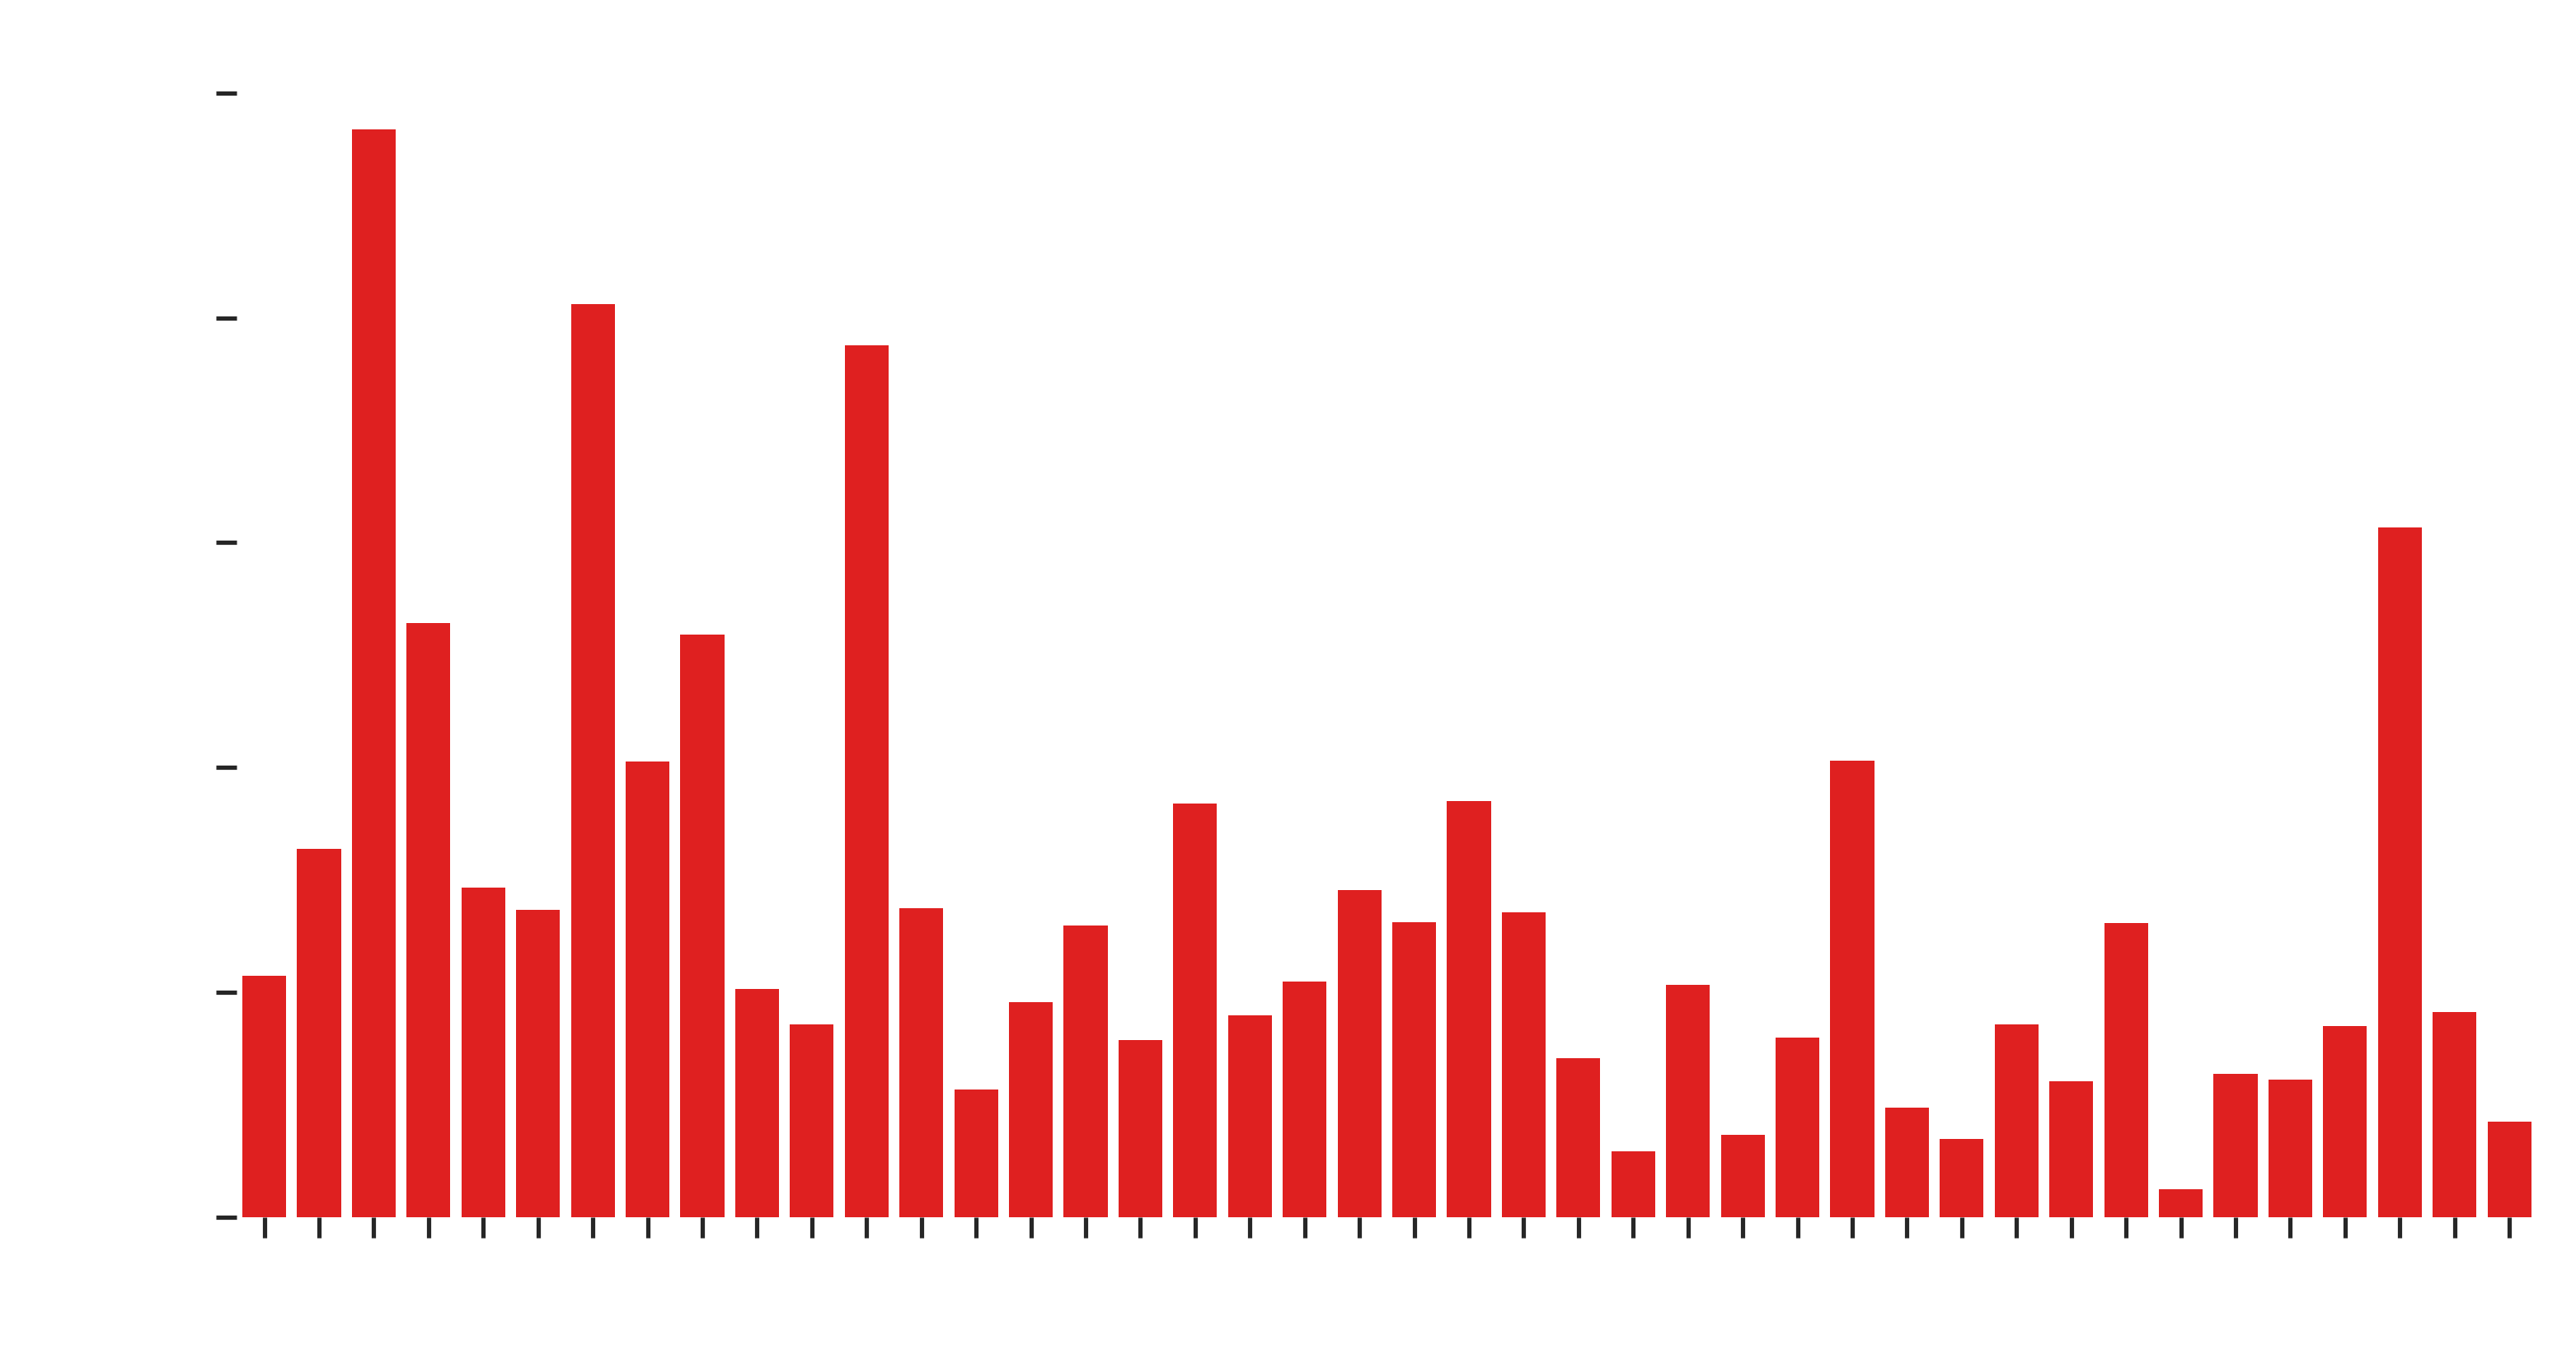

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size with fully transparent background
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none', dpi=300)  # Increase DPI for better resolution


# Create bar plot with transparent outlines
sns.barplot(data=final_df, x='Year', y='Burned Area (ha)', color='red', edgecolor="none", ax=ax)

# Customize the plot
ax.set_xlabel('', color='white')  # White x-axis label
ax.set_ylabel('Burned Area (ha)', color='white')  # White y-axis label
ax.set_title('Burned Area per Year', color='white')  # White title

# Rotate x-axis labels and change their color
plt.xticks(rotation=45, color='white')  
plt.yticks(color='white')

# Make spines (borders) fully transparent
for spine in ax.spines.values():
    spine.set_visible(False)

# Set grid color to white
ax.grid(axis='y', linestyle='--', alpha=0.7, color='white')

# Make both the figure and axes background transparent
ax.set_facecolor('none')  # Transparent background for the plot area
fig.patch.set_alpha(0)  # Fully transparent figure background

# Show the plot
plt.show()



## Import temperature by year

In [41]:
tempS_data = pd.read_csv("average-mean-surface-air_Spain.csv", sep=",")
tempS_df = tempS_data.copy()


tempS_df

,Year,Annual Average Mean Surface Air Temperature,Trend 1951-2020,Trend 1971-2020,Trend 1991-2020
0,1950,13.50,NaN,NaN,NaN
1,1951,12.47,12.471851,NaN,NaN
2,1952,12.84,12.502795,NaN,NaN
3,1953,12.98,12.533740,NaN,NaN
4,1954,12.70,12.564684,NaN,NaN
...,...,...,...,...,...
69,2019,14.61,14.576062,14.778417,14.623056
70,2020,14.71,14.607006,14.820494,14.654344
71,2021,14.30,NaN,NaN,NaN
72,2022,15.49,NaN,NaN,NaN


### data cleaning

In [42]:
tempS_df.drop(columns=["Trend 1951-2020", "Trend 1971-2020", "Trend 1991-2020"], inplace=True)
tempS_df.rename(columns={"Annual Average Mean Surface Air Temperature": "Average Temperature"}, inplace=True)

# Now tempS_df is correctly modified
tempS_df


,Year,Average Temperature
0,1950,13.50
1,1951,12.47
2,1952,12.84
3,1953,12.98
4,1954,12.70
...,...,...
69,2019,14.61
70,2020,14.71
71,2021,14.30
72,2022,15.49


In [43]:
all_df = pd.merge(final_df, tempS_df, on="Year", how="inner")

all_df["Burned Area (ha)"] = all_df["Burned Area (ha)"].astype(int)

all_df

,Year,Burned Area (ha),Number of Fires,Average Temperature
0,1983,107151,3403.0,13.65
1,1984,163755,5614.0,12.71
2,1985,483843,10119.0,13.56
3,1986,264276,5665.0,13.28
4,1987,146689,6454.0,13.90
5,1988,136607,6743.0,13.55
6,1989,405892,15922.0,14.41
7,1990,202489,8413.0,14.11
8,1991,258953,7450.0,13.38
9,1992,101608,7336.0,13.28


(12.0, 17.0)

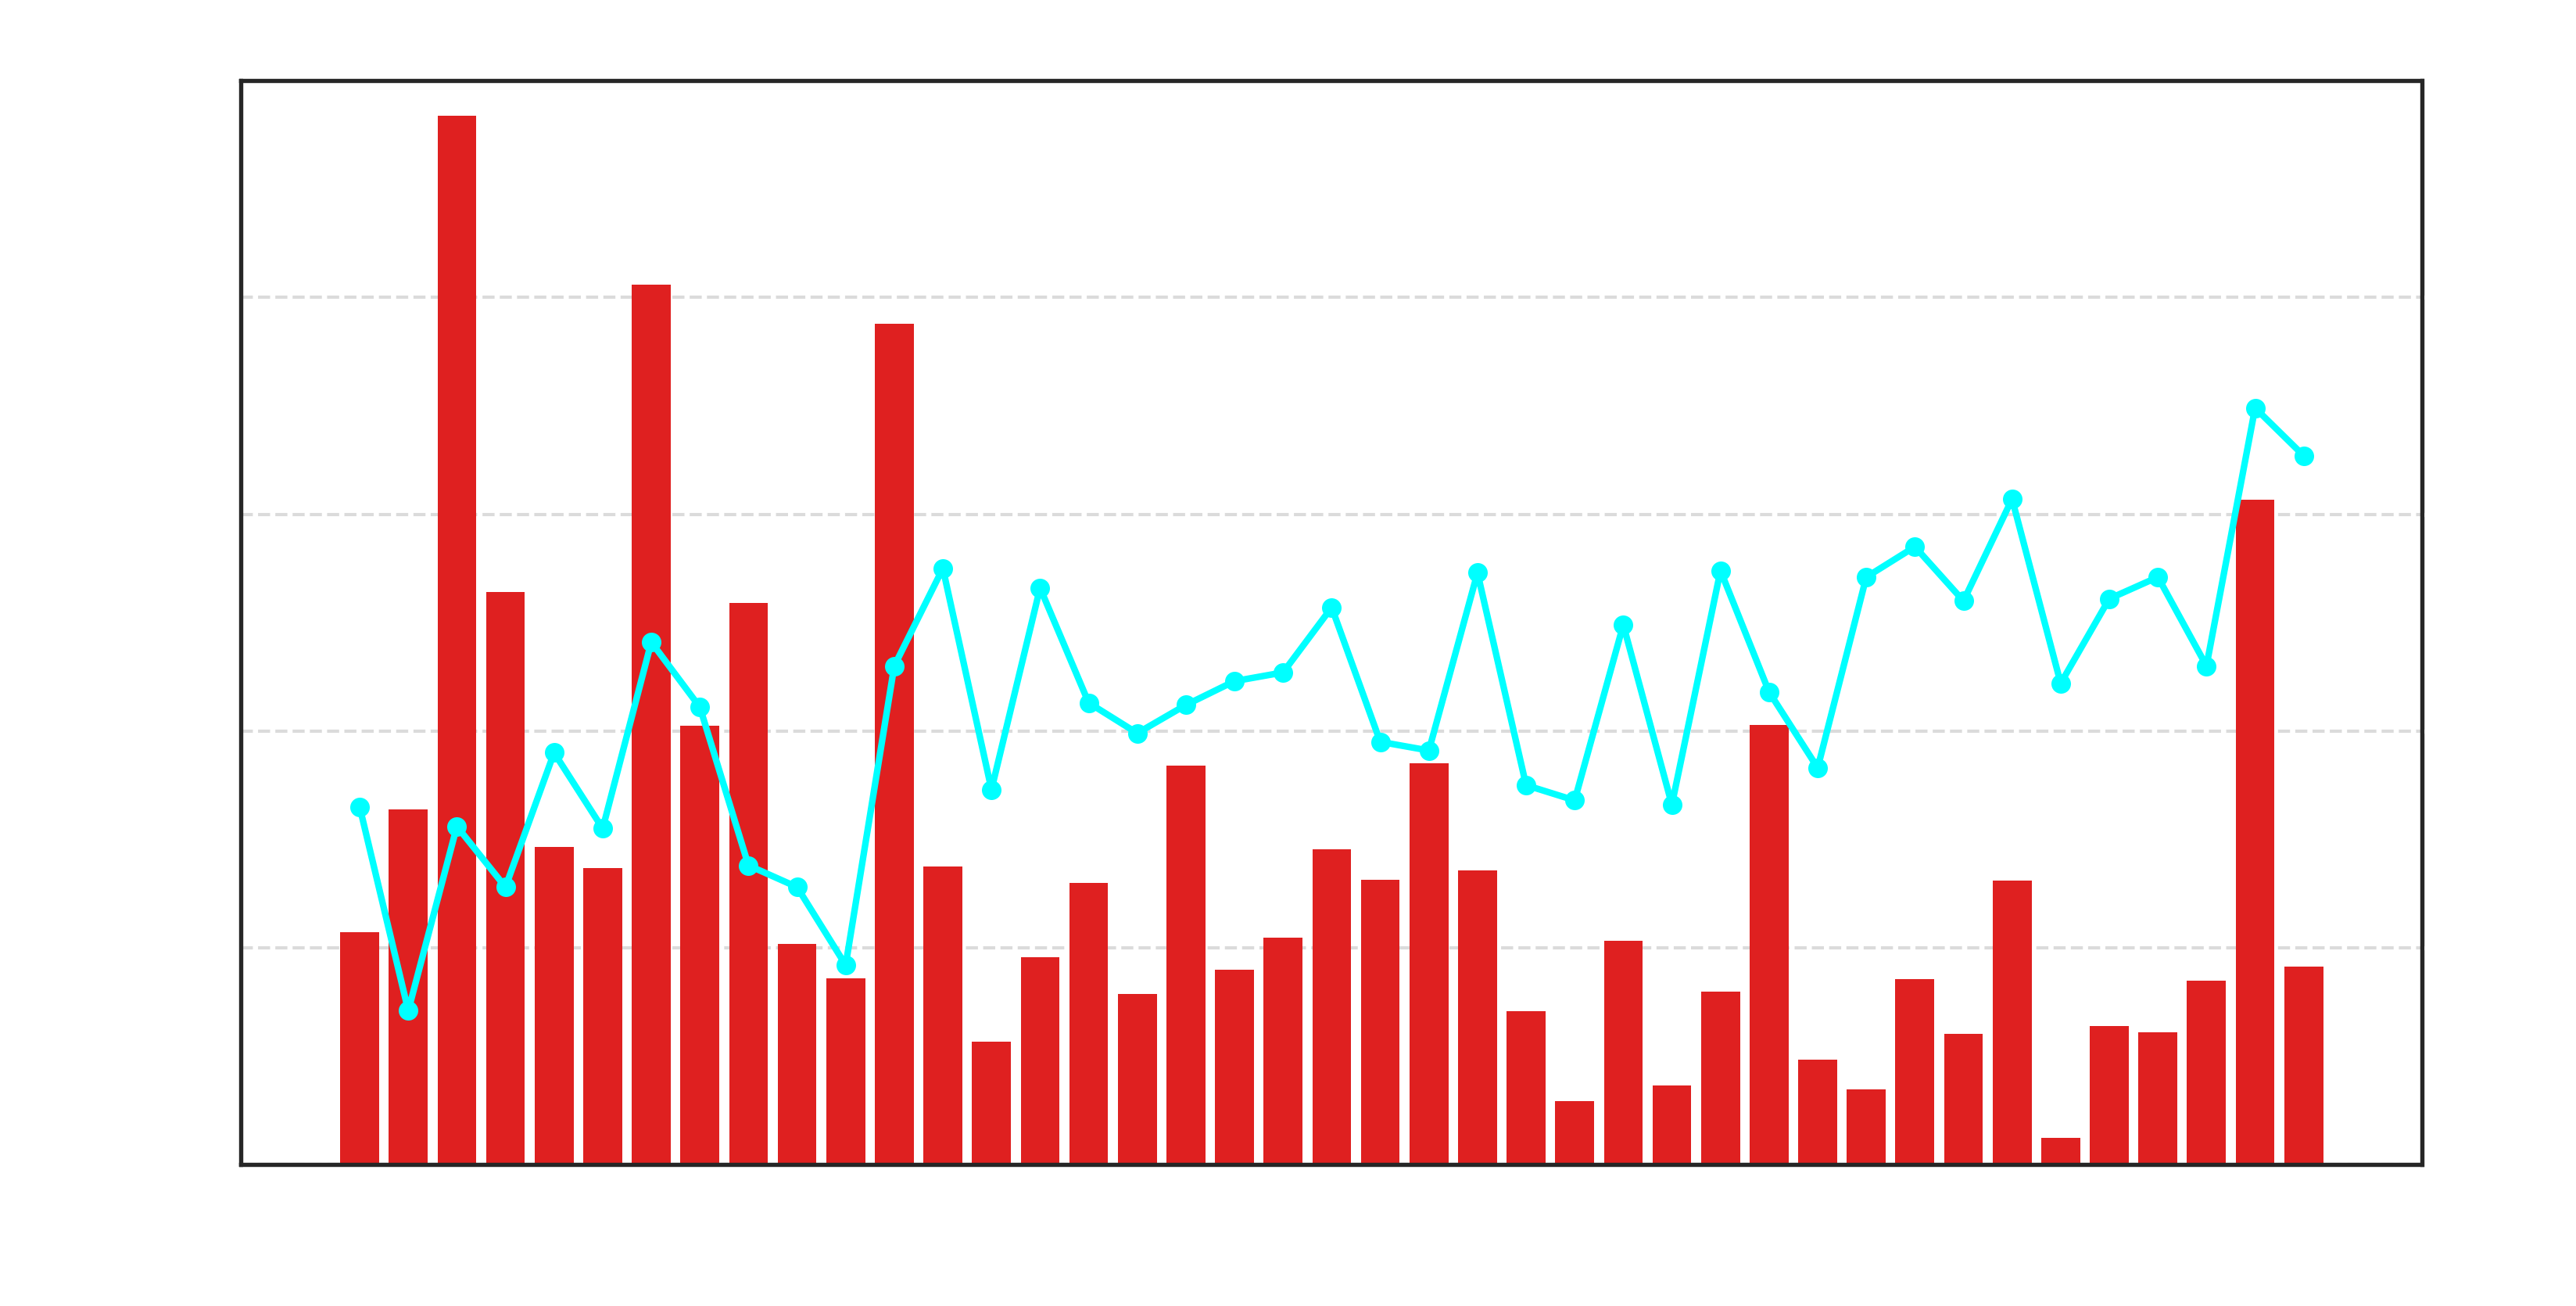

In [44]:



ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='none', dpi=300)


 

# Rotate x-axis labels and change their color
plt.xticks(rotation=45, color='white')  
plt.yticks(color='white')


sns.barplot(data = all_df, x='Year', y='Burned Area (ha)', color ="red", edgecolor="none", ax=ax1)

# Customize labels and title (Set to white)
ax1.set_xlabel("", fontsize=14, color='white')  
ax1.set_ylabel("Burned Area (ha)", fontsize=14, color='white')  
ax1.set_title("Burned Area per Year", fontsize=16, color='white')  

# Make tick labels pure white
ax1.tick_params(axis='x', colors='white', labelsize=12)
ax1.tick_params(axis='y', colors='white', labelsize=12)


# Add grid lines to primary y-axis (Burned Area)
ax1.grid(axis='y', linestyle='--', alpha=0.7)  # Dashed grid lines for better visibility
ax1.set_ylim(0,500000)

ax2 = ax1.twinx()


# Make both figure and axes background completely transparent
ax1.set_facecolor('none')  # Transparent background for the bar plot
ax2.set_facecolor('none')  # Transparent background for the line plot
fig.patch.set_alpha(0)  # Fully transparent figure background

# Set second y-axis properties
ax2.set_ylabel("Average Temperature (°C)", fontsize=14, color='white')
ax2.tick_params(axis='y', colors='white', labelsize=12)
ax2.set_ylim(12, 17) 

sns.lineplot(data = all_df['Average Temperature'],  marker='o',markeredgewidth= 0, color= "cyan", sort = False, ax=ax2, linewidth = 2)
ax2.set_ylim(12, 17) # This is not the appropriate way !!!





## To-do

- Why are there so many intentional wildfires?
    - related to land use? -> pasture?
- What is the relationship between eucalyptus plantations and wildfires?
    - Are fires in the same place as eucalyptus?
        -> Test correlation (Use wildfires after the year of tree map data)
            - find date of tree species study


----

- [x] combine wf_df and fdC_df into one small dataset: amount of wildfires, total area burned, year
- [x] find dataset for temperatures in Spain: Year, Temeperature 